In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys
from sklearn.neighbors import KernelDensity

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [3]:
sys.path.append('../src/cWGAN/')
import model

In [4]:
save_dir = '../models/cWGAN/Run_2020-11-30_0/'
assert(os.path.isdir(save_dir))

In [27]:
#losses = np.loadtxt(save_dir + 'losses.txt', skiprows=1)
#print(losses)
losses = []
with open(save_dir+'losses.txt', 'r') as f:
    for _ in range(2000):
        line = f.readline()
        start = int(line.find('('))
        end = int(line.find(','))
        if start > 0:
            losses.append(float(line[start+1:end]))
#print(losses)

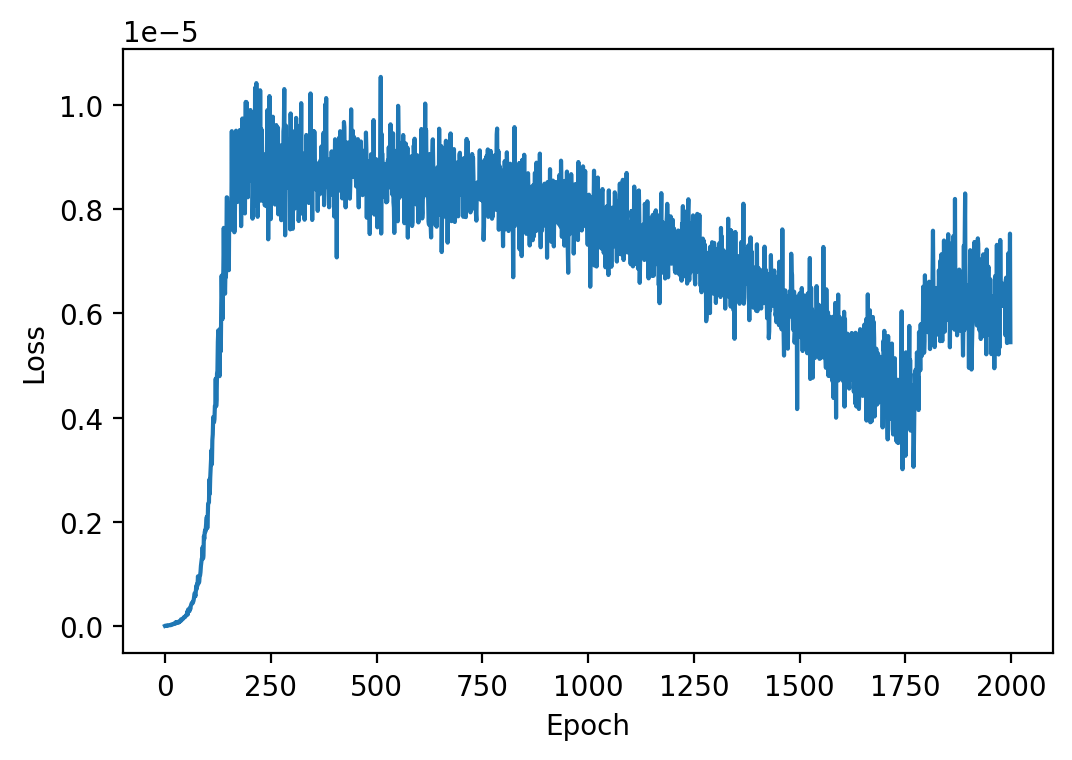

In [28]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

ax.plot(losses)
#ax.plot(losses[:, 1], label='Training Gen Loss')
#ax.plot(losses[:, 2], label='Training Disc Loss')
#ax.plot(losses[:, 1]/losses[0, 1], label='Training Gen Loss')
#ax.plot(losses[:, 2]/losses[0, 2], label='Training Disc Loss')
#ax.plot(losses[:, 3]/losses[0, 1], label='Val Gen Loss')
#ax.plot(losses[:, 4]/losses[0, 2], label='Val Disc Loss')
#ax.set_ylim(0.0075, 0.012)
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
#plt.yscale('log')
#ax.legend()
plt.show()

In [7]:
gen = model.make_generator()
disc = model.make_discriminator()

In [361]:
gen.load_weights(save_dir + '/training_checkpoints/gen_250')

In [362]:
data = np.loadtxt("../data/processed/matchedJets.txt", skiprows=2)

In [363]:
print(data[0])

[41.4024   -1.27316  -0.891338 80.6118   36.3716   -1.24909  -0.87713
 69.0265  ]


In [364]:
partonPtMax = np.max(data[:, 0], axis=0)
partonPtMin = np.min(data[:, 0], axis=0)
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)

genPtMax = np.max(data[:, 4], axis=0)
genPtMin = np.min(data[:, 4], axis=0)
genMean = np.mean(data[:, 5:7], axis=0)
genStd = np.std(data[:, 5:7], axis=0)
genEMax = np.max(data[:, 7], axis=0)
genEMin = np.min(data[:, 7], axis=0)

data[:, 0] = (data[:, 0] - partonPtMin)/partonPtMax
data[:, 1:3] = (data[:, 1:3] - partonMean)/partonStd
data[:, 3] = (data[:, 3] - partonEMin)/partonEMax
#data[:, 4] = (data[:, 4] - genPtMin)/genPtMax
#data[:, 5:7] = (data[:, 5:7] - genMean)/genStd
#data[:, 7] = (data[:, 7] - genEMin)/genEMax
print(data[0])

[ 1.53818124e-02 -8.89597460e-01 -4.90113027e-01  1.24261265e-02
  3.63716000e+01 -1.24909000e+00 -8.77130000e-01  6.90265000e+01]


In [365]:
noise = np.random.normal(size=data[:, 0:4].shape)
print(noise.shape)


(646517, 4)


In [366]:
%%time
predict = gen.predict([data[:, 0:4], noise])

CPU times: user 10.9 s, sys: 665 ms, total: 11.5 s
Wall time: 6.6 s


In [367]:
print(predict[0])

[ 0.02717986 -0.9283862  -0.50904834  0.02208938]


In [368]:
predict[:, 0] = predict[:, 0]*partonPtMax + partonPtMin
predict[:, 1:3] = predict[:, 1:3] * partonStd + partonMean
predict[:, 3] = predict[:, 3]*partonEMax + partonEMin

In [369]:
print(predict[0])
data[:, 0] = data[:, 0]*partonPtMax + partonPtMin
#data[:, 4] = data[:, 0]*genPtMax + genPtMin

[ 57.818085   -1.3285892  -0.9257024 127.61118  ]


In [370]:
print(data[0, 0])
print(data[0, 4])
partonPt = []
genPt = []
predictedPt = []
for i in range(len(data)):
    if (data[i, 0] > 142.5 and data[i, 0] < 157.5):
        genPt.append(data[i, 4])
        predictedPt.append(predict[i, 0])

41.4024
36.3716


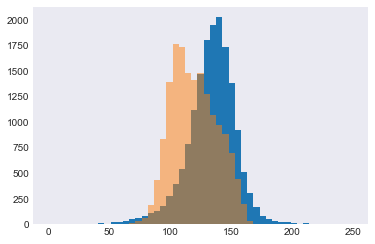

In [371]:
bins = np.linspace(0, 250, 50)
plt.hist(genPt, bins=bins)
plt.hist(predictedPt, bins=bins, alpha=0.5)
plt.show()


In [372]:
plt.style.use('seaborn-dark')

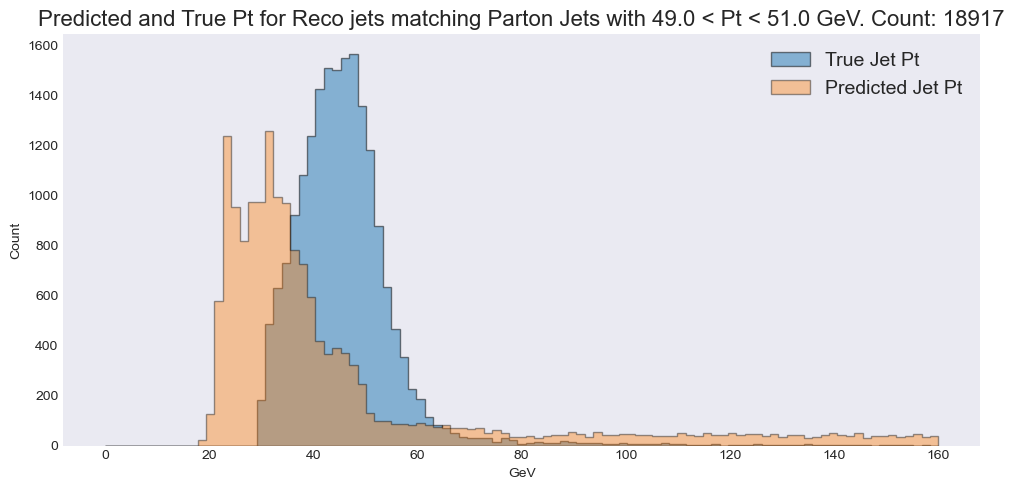

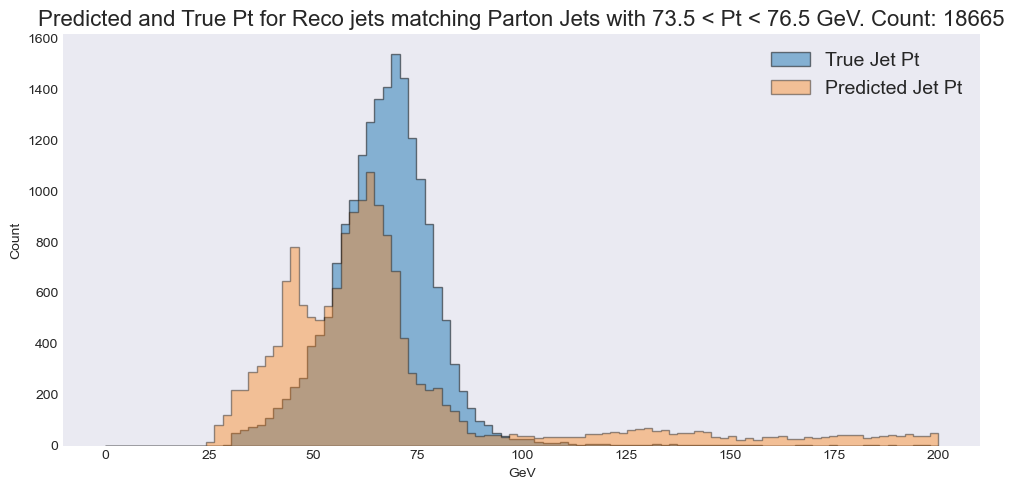

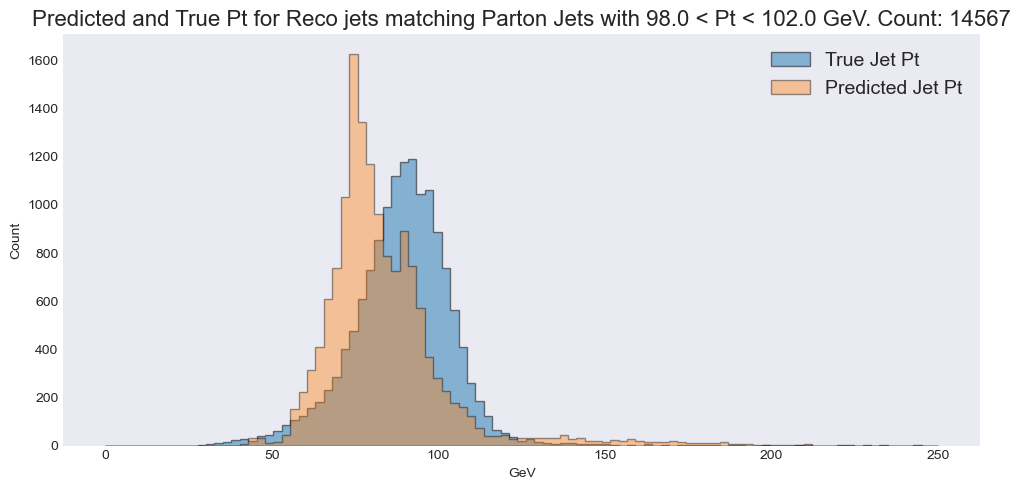

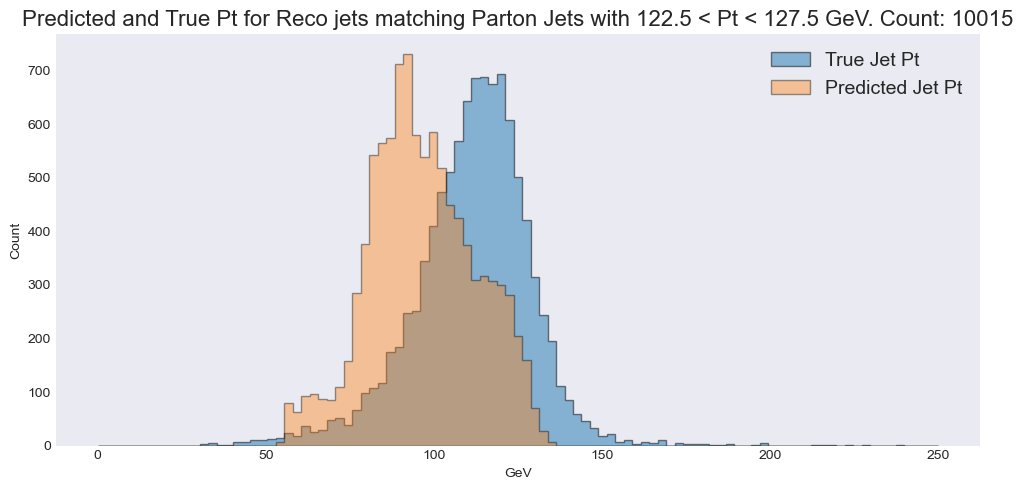

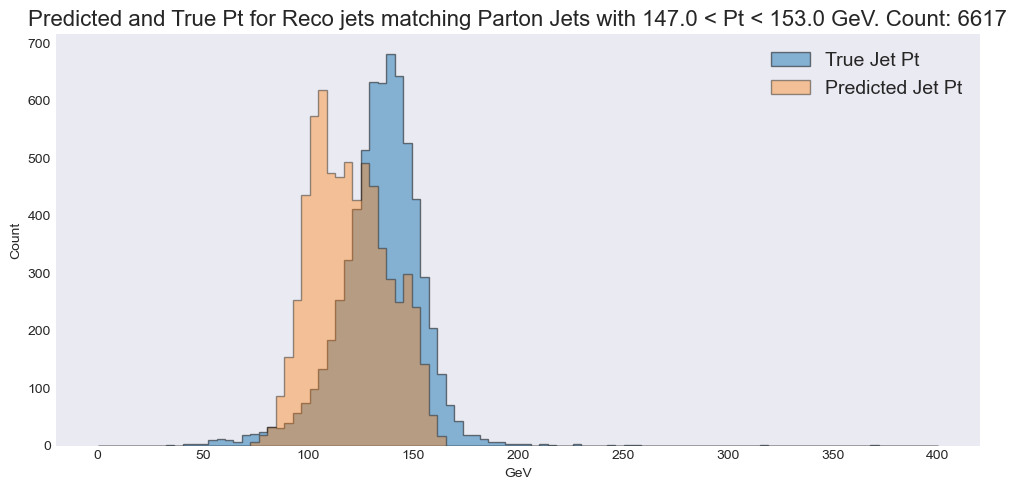

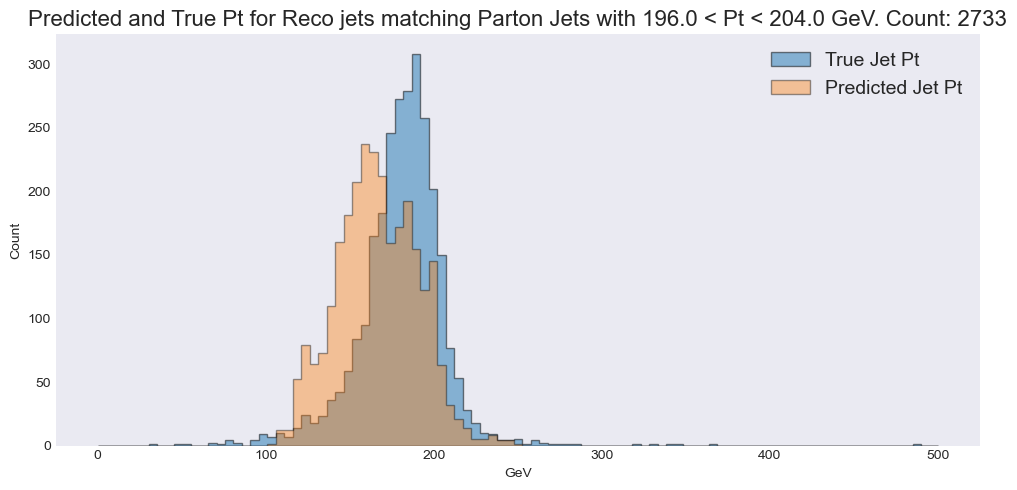

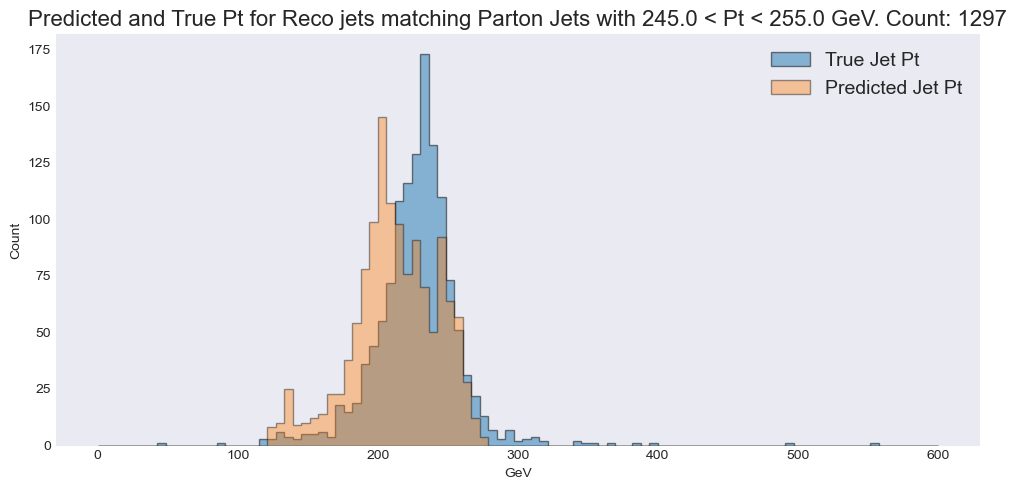

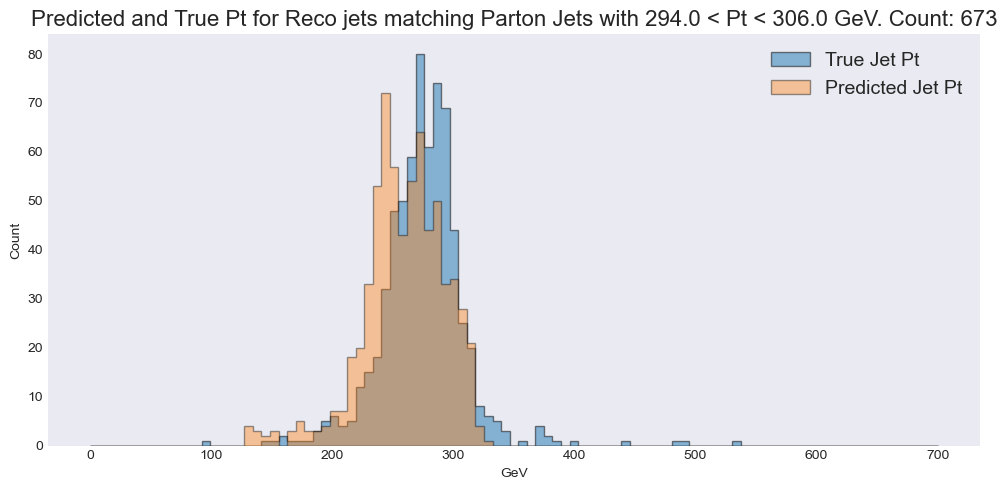

In [373]:
range_highs = [160, 200, 250, 250, 400, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [50, 75, 100, 125, 150, 200, 250, 300]:        
    recoPt = []
    predPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1

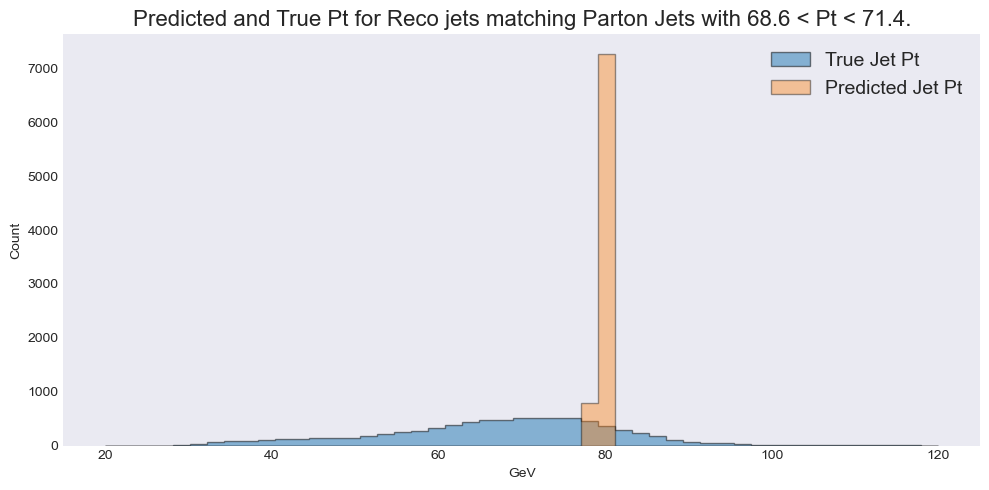

In [76]:
range_highs = [120]
range_lows = [20]
j = 0
for center in [70]:        
    recoPt = []
    partonPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(data)):
        if (data[i, 0] > 79 and data[i, 0] < 81):
            recoPt.append(data[i, 4])
            partonPt.append(data[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 50)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(partonPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {}.".format(low, high), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1

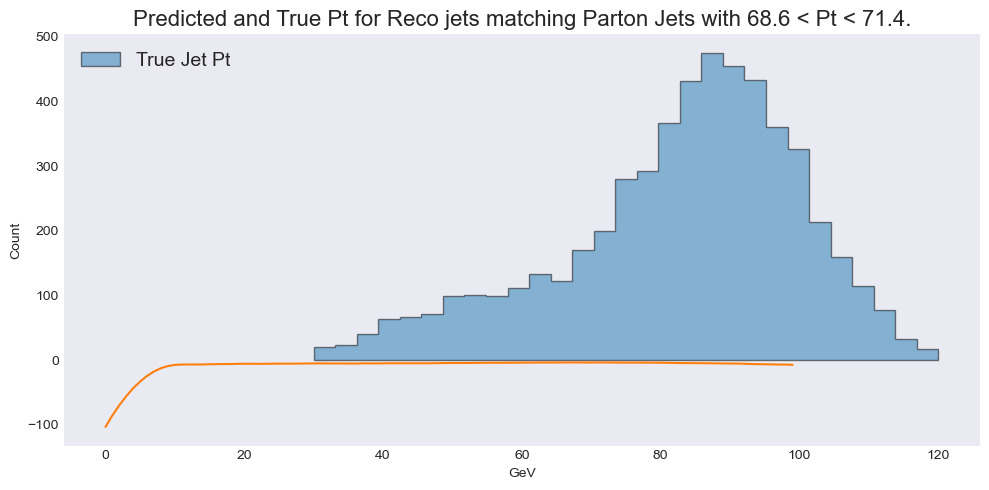

In [29]:
bins = np.linspace(30, 120, 30)
fig = plt.figure(figsize=(10,5), dpi=100)
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(np.array(recoPt)[:, np.newaxis])
ax = fig.add_subplot(111)
ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
#ax.hist(partonPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
#ax.hist(energy, bins=bins, label='E', alpha=0.5)
ax.set_xlabel("GeV")
ax.set_ylabel("Count")

X_plot = np.linspace(20, 120, 100)[:, np.newaxis]
ax.plot(kde.score_samples(X_plot))


ax.set_title("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {}.".format(low, high), fontsize=16)
#ax.axvline(x=center/2)

ax.legend(fontsize=14)
plt.tight_layout()
#ax.set_yscale('log')
plt.show()

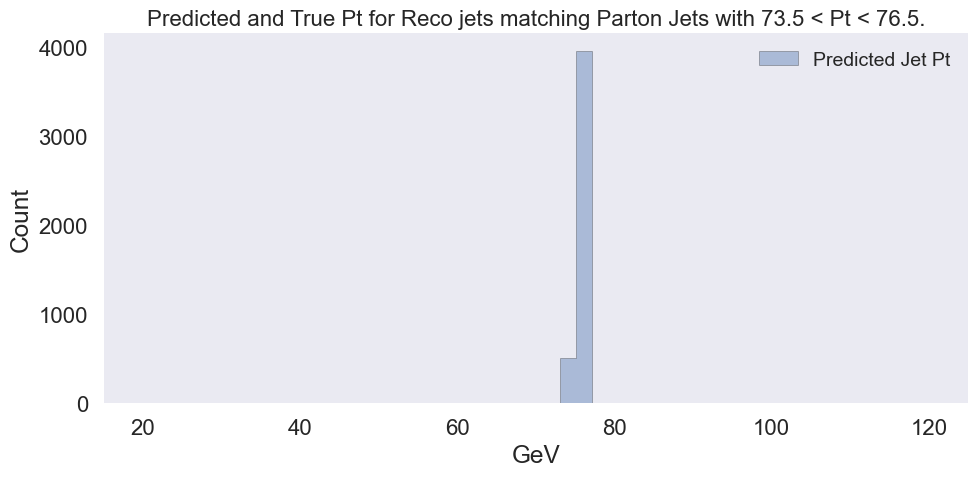

In [105]:
fig = plt.figure(figsize=(10,5), dpi=100)
ax = fig.add_subplot(111)
#ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(partonPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
#ax.hist(energy, bins=bins, label='E', alpha=0.5)
ax.set_xlabel("GeV")
ax.set_ylabel("Count")
ax.set_title("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {}.".format(low, high), fontsize=16)
#ax.axvline(x=center/2)

ax.legend(fontsize=14)
plt.tight_layout()
#ax.set_yscale('log')
plt.show()

In [30]:
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

In [82]:
X = np.array(recoPt)[:, np.newaxis]
X_plot = np.linspace(20, 120, 500)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(X)
log_dens = kde.score_samples(X_plot)

In [58]:
print(np.exp(log_dens))

[2.79643020e-05 7.04396151e-05 1.55418457e-04 3.03353461e-04
 5.30146994e-04 8.41065482e-04 1.22886616e-03 1.67625943e-03
 2.16031757e-03 2.65770372e-03 3.15062038e-03 3.63057620e-03
 4.09534185e-03 4.54025167e-03 4.95363628e-03 5.32488405e-03
 5.65961544e-03 5.98537858e-03 6.33980430e-03 6.75405088e-03
 7.25108191e-03 7.85989319e-03 8.62551823e-03 9.59807055e-03
 1.08084188e-02 1.22533496e-02 1.39020908e-02 1.57133614e-02
 1.76419747e-02 1.96246498e-02 2.15562027e-02 2.32811585e-02
 2.46175441e-02 2.54046388e-02 2.55479026e-02 2.50371432e-02
 2.39317862e-02 2.23267115e-02 2.03243186e-02 1.80323680e-02
 1.55792712e-02 1.31148964e-02 1.07797568e-02 8.66614790e-03
 6.80853610e-03 5.20876556e-03 3.86650542e-03 2.78745895e-03
 1.97047925e-03 1.39347107e-03]


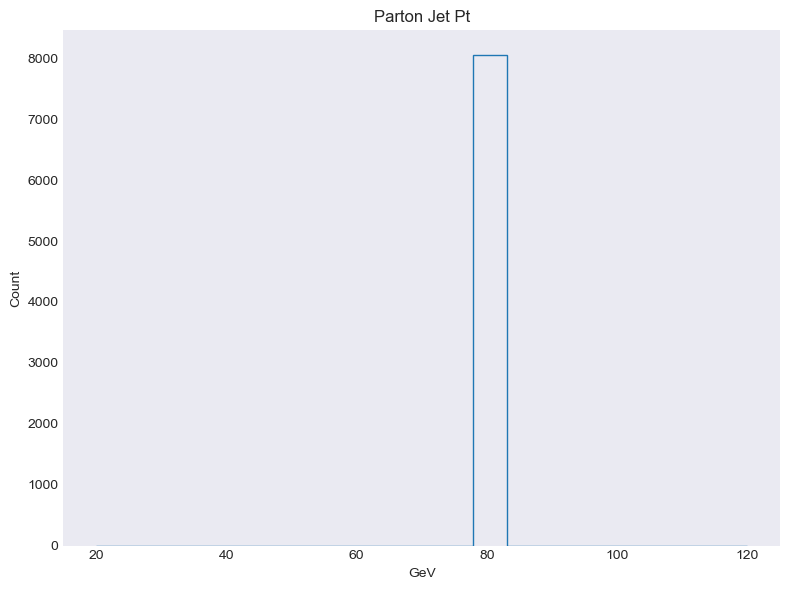

In [88]:
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(partonPt, bins=np.linspace(20, 120, 20), histtype='step')
ax.set_xlabel("GeV")
ax.set_ylabel("Count")
ax.set_title("Parton Jet Pt")
plt.tight_layout()
fig.savefig("PtDistParton.pdf", facecolor="white")
plt.show()

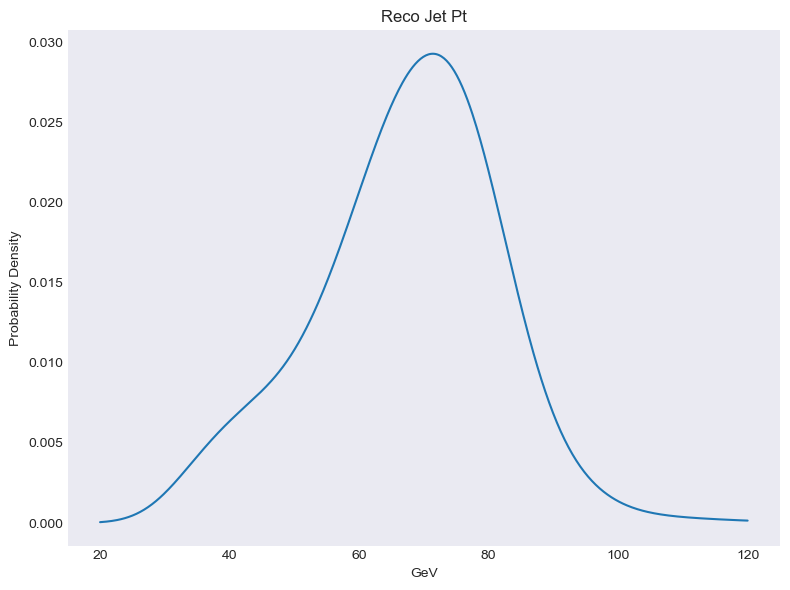

In [90]:
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.plot(X_plot, np.exp(log_dens))
ax.set_xlabel("GeV")
ax.set_ylabel("Probability Density")
ax.set_title("Reco Jet Pt")
plt.tight_layout()
fig.savefig("PtDistReco.pdf", facecolor="white")
plt.show()